Reproduz CURVATURA.M ANDREA PARA PYTHON

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from collections import deque
import math

In [2]:
vx= 'MECH128X.dat'
vy= 'MECH128Y.dat'
nu= 128
sigma=100
tresh=0.4    #analisar (automatizar...)
n = nu

In [3]:
 # organiza valores dos vetores lidos (arq Andrea) a partir da posição 1 (lidos com 129 elem, necessários 128):
xt = np.loadtxt(vx)
yt = np.loadtxt(vy)
for i in np.arange(xt.shape[0])[::-1]:
    xt[i] = xt[i-1]
    yt[i] = yt[i-1]
xt[0] = xt[1]
yt[0] = yt[1]

n=nu
xorig=xt
yorig=yt


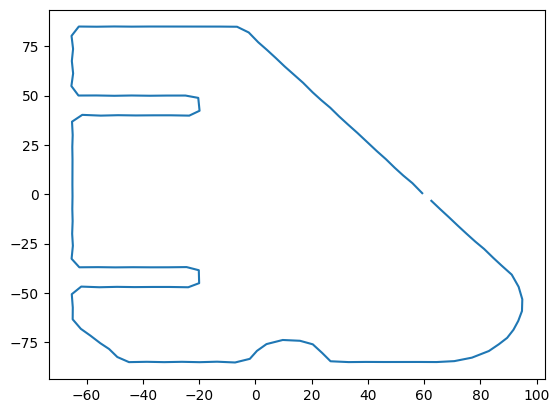

In [4]:
#plot xt vs yt
plt.plot(xt, yt)

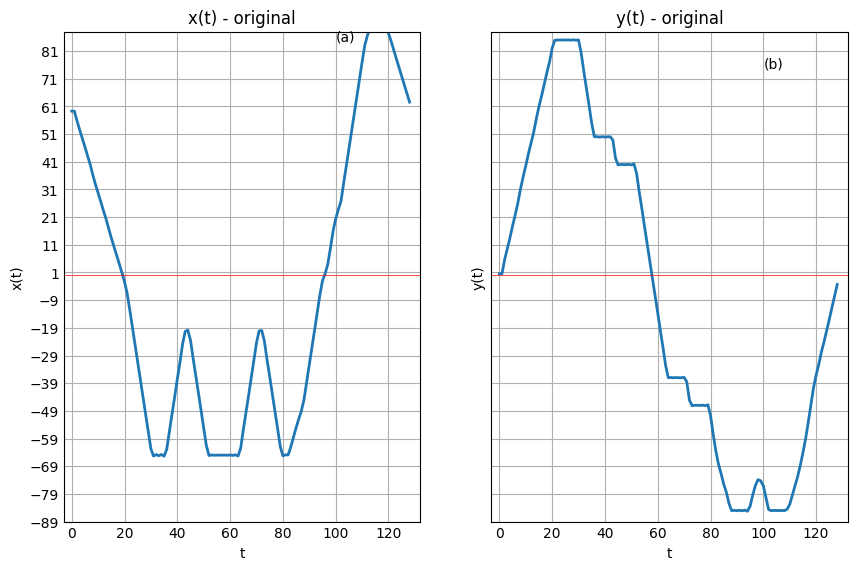

In [5]:
plt.style.use('_mpl-gallery')
fig, axis = plt.subplots(1, 2, figsize=(8,5), sharey=True, sharex=True)  #layout = 'tight'
axis[0].plot(np.arange(xt.shape[0]), xt,  linewidth=2.0)
axis[0].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       ylim=(np.min(xt)-3, np.max(xt)+3), yticks=np.arange(np.floor(np.min(xt)-3),\
       np.max(xt)+3, 10), xlabel= 't', ylabel = 'x(t)', title = 'x(t) - original', \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str))
axis[0].text(100, np.max (xt)-10, '(a)')
axis[0].axhline(0,0,1, linewidth = 0.5, color='r')
axis[1].plot(np.arange(yt.shape[0]), yt,  linewidth=2.0)
axis[1].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       ylim=(np.min(yt)-3, np.max(yt)+3), yticks=np.arange(np.floor(np.min(yt)-3),\
       np.max(yt)+3, 10), xlabel= 't', ylabel = 'y(t)', title = 'y(t) - original', \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str))
axis[1].text(100, np.max (yt)-10, '(b)')
axis[1].axhline(0,0,1, linewidth = 0.5, color='r')
plt.subplots_adjust(wspace = 0.2)
plt.show() 


In [6]:
# Shift 
xad = np.zeros((nu + 1))
xad[0] = 0
for i in range(1, xad.shape[0]):
    xad[i]=(-1)**(i-1)
xad[0] = 0
vx=xt*xad
vy=yt*xad

In [7]:
# Função filtro gauss:
def gaus_filter(n, n_median, sig):
   # n: numero de dados
   #n_median: posição para o vr maximo da curva de Gaus (ex. n/2) 
   #sigma: desvio padrão da gausiana
   gaus_f = np.zeros(n , dtype = complex)   
   for i in np.arange(n):
      gaus_f[i] = (1./(sig*(np.sqrt(2*np.pi))))*np.exp((-1*(i- n_median)**2)/(2*sig**2))
   return gaus_f
 
# Calcula o espectro de energia do vetor transformado antes da gaussina
def calc_energy(tf):
    et = np.zeros(tf.shape[0], dtype = np.float32)
    for i in np.arange(tf.shape[0]):
        et[i] = (np.real(tf[i])**2) + (np.imag(tf[i])**2) 
    return et, np.sum(et)

In [8]:
# Calcula as transformadas de Fourier dos vetores X e Y
tx=np.fft.fft(vx[1:],n)/n
ty=np.fft.fft(vy[1:],n)/n

In [9]:
ex, Soex =  calc_energy(tx)
ey, Soey = calc_energy(ty)
Soex, Soey

(2782.8267, 3480.7617)

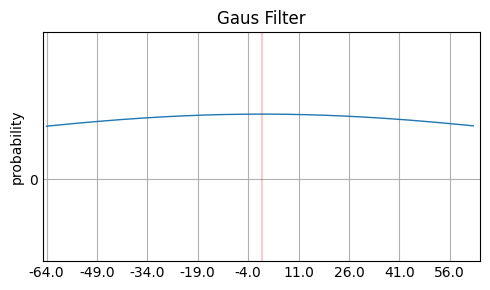

0.003989422804014327

In [10]:
## Plota Filtro gaussiana:
gaus = gaus_filter(n,n/2, sigma)
fig, axis = plt.subplots(figsize=(5,3),layout = 'tight')
axis.plot(np.arange(-n/2, n/2, 1), np.real(gaus), linewidth=1.0)
axis.set(xlim=(-n/2-1,n/2+1), xticks=np.arange(-n/2, n/2, 15), \
       ylim=(-0.005, np.max(np.real(gaus))+0.005), yticks=np.arange(0, np.max(np.real(gaus))+0.001, 0.01), \
       ylabel = 'probability', title = 'Gaus Filter', \
       xticklabels = np.array(np.arange(-n/2, n/2, 15).astype(str)))
axis.axvline(0,0,1, linewidth = 0.3, color='r')
plt.show()
np.max(np.real(gaus))

In [11]:
# Multipla a gaussiana pelas transformadas
gaus = gaus_filter(n, n/2, sigma)
tgx = np.zeros(tx.shape[0], dtype=complex) 
#for i in np.arange(tgx.shape[0]):
#    tgx[i] = tx[i]*gaus[i]
tgx = tx*np.fft.fft(gaus)
tgy= ty*np.fft.fft(gaus)    

In [12]:
#Calcula o grafico do espectro de energia para os vetores X e Y com a gaussiana
egx, Soegx= calc_energy(np.copy(tgx))
egy, Soegy= calc_energy(np.copy(tgy))
Soegx, Soegy

(0.00022055369, 8.939914e-05)

In [13]:
# Para multiplicarmos o espectro pela gaussiana, devemos realizar uma compensao
# devido ao efeito da gaussiana, essa compensacao e obtida pelos coeficientes gamax e gamay.

gamax=np.sqrt(Soex/Soegx)
gamay=np.sqrt(Soey/Soegy)
gamax, gamay

(3552.106, 6239.7974)

In [14]:
# Calcula as derivadas de primeira e segunda ordem a partir das transformadas:
dgx = np.zeros(n, dtype=complex)    # multiplicador da 1a derivada  
dgx2= np.zeros(n, dtype=complex)   # multiplicador de 2a derivada
n2=np.floor(n/2).astype(int)
for t in np.arange(-n2,(n-n2-1)+1,1):     #Não segue a fórmula do artigo. Falta multiplicar por 2*pi
   dgx[t+n2]=(t-1)*(1j)    ## tem certeza que é (t-1)? pois (t-1) estará no intervalo [-65:63]?
   dgx2[t+n2]=(dgx[t+n2]**2)

#t=-n2:1:n-n2-1;  (?)

vgx=tgx*dgx     # dx
vgy=tgy*dgx     # dy
vgx2=tgx*dgx2   # dx2
vgy2=tgy*dgx2   # dy2


In [15]:
# inversas dos vetores X e Y com as Gaussianas
trix=np.fft.ifft(tgx)*n
triy=np.fft.ifft(tgy)*n

txi=np.fft.ifft(vgx)*n      # porque dividir o espetro por n, pra ter que agora multiplicar?
tyi=np.fft.ifft(vgy)*n      # e se tem de multiplicar nao seria antes de inverter (ifft)?

txi2=np.fft.ifft(vgx2)*n
tyi2=np.fft.ifft(vgy2)*n

In [16]:
#dgx[0],dgx[1], dgx[3], dgx[126], dgx[127], np.sum(dgx)
vgx[0],vgx[1], vgx[3], vgx[126], vgx[127], np.sum(vgx)

(-0.9634992829451169j,
 (-0.0326603372242879+0.003373789572574152j),
 (0.0006816336078447568+7.939013720455978e-05j),
 (0.000810519585736956+0.0005229188915086487j),
 (-0.031639701686027824-0.0032683586484333668j),
 (-0.06066178969902744-0.9628128321270223j))

In [17]:
# Compensacao do valor por gamax e gamay

txi=txi*gamax;     #a compensação foi calculada em fourier e multiplicada no dominio do tempo?
tyi=tyi*gamay;   

txi2=txi2*gamax;
tyi2=tyi2*gamay;

trix=trix*gamax;
triy=triy*gamay;

In [18]:
# Retorna o sinal ao local anterior

for t in np.arange(n):           # original t=1:n     # a inversao não seria antes de inverter com ifft?
  txi[t]  =txi[t]*((-1)**(t));   # txi[t]*((-1)**(t-1));
  tyi[t]  =tyi[t]*((-1)**(t));
  txi2[t] =txi2[t]*((-1)**(t));
  tyi2[t] =tyi2[t]*((-1)**(t));
  trix[t] =trix[t]*((-1)**(t));
  triy[t] =triy[t]*((-1)**(t));

#trix = np.real(trix)
dx = np.real(txi)
dx2 = np.real(txi2)
#triy = np.real(triy)
dy = np.real(tyi)
dy2 = np.real(tyi2)

c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\transforms.py:2855: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:895: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))


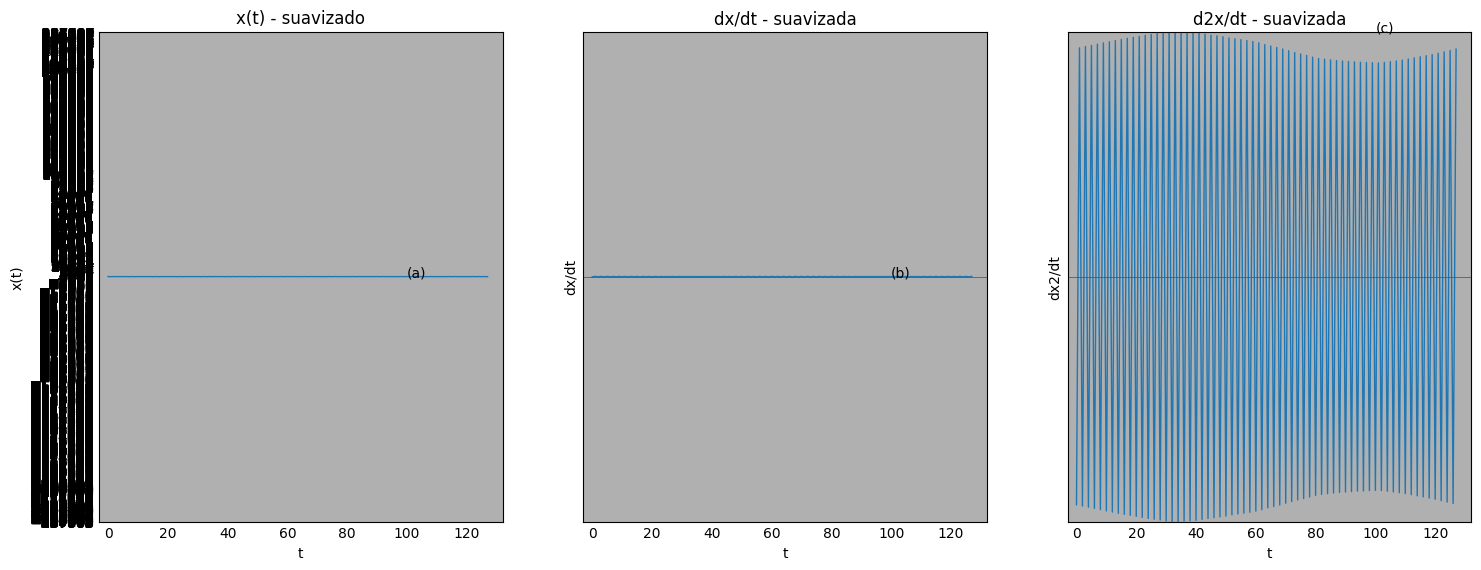

In [19]:
# Plota os valores das derivadas x(t), dx/dt e dx2/dt (original e deriv. de primeira e segunda ordem)
fig, axis = plt.subplots(1, 3, figsize=(14,5), sharey=True, sharex=True)  #layout = 'tight'
axis[0].plot(np.arange(n), trix,  linewidth=1.0)
axis[0].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str), \
       ylim=(np.min(trix)-3, np.max(trix)+3), 
       yticks=np.arange(np.min(trix),np.max(trix), 100), 
       xlabel= 't', ylabel = 'x(t)', title = 'x(t) - suavizado')
axis[0].text(100, np.max(trix)-10, '(a)')
#axis[0].axhline(0,0,1, linewidth = 0.5, color='r')

axis[1].plot(np.arange(n), dx,  linewidth=1.0)
axis[1].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str), \
       ylim=(np.min(dx)-3, np.max(dx)+3), 
       yticks=np.arange(np.floor(np.min(dx)),np.max(dx), 100), 
       xlabel= 't', ylabel = 'dx/dt', title = 'dx/dt - suavizada')
axis[1].text(100, np.max (dx)-0.10, '(b)')
axis[1].axhline(0,0,1, linewidth = 0.5, color='r')

axis[2].plot(np.arange(n), dx2,  linewidth=1.0)
axis[2].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str), \
       ylim=(np.min(dx2)-3, np.max(dx2)+3), 
       yticks=np.arange(np.floor(np.min(dx2)),np.max(dx2), 100), 
       xlabel= 't', ylabel = 'dx2/dt', title = 'd2x/dt - suavizada')
axis[2].text(100, np.max (dx2)-0.10, '(c)')
axis[2].axhline(0,0,1, linewidth = 0.5, color='r')

plt.subplots_adjust(wspace = 0.2)
plt.show()  

c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\transforms.py:2855: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:754: ComplexWarning: Casting complex values to real discards the imagin

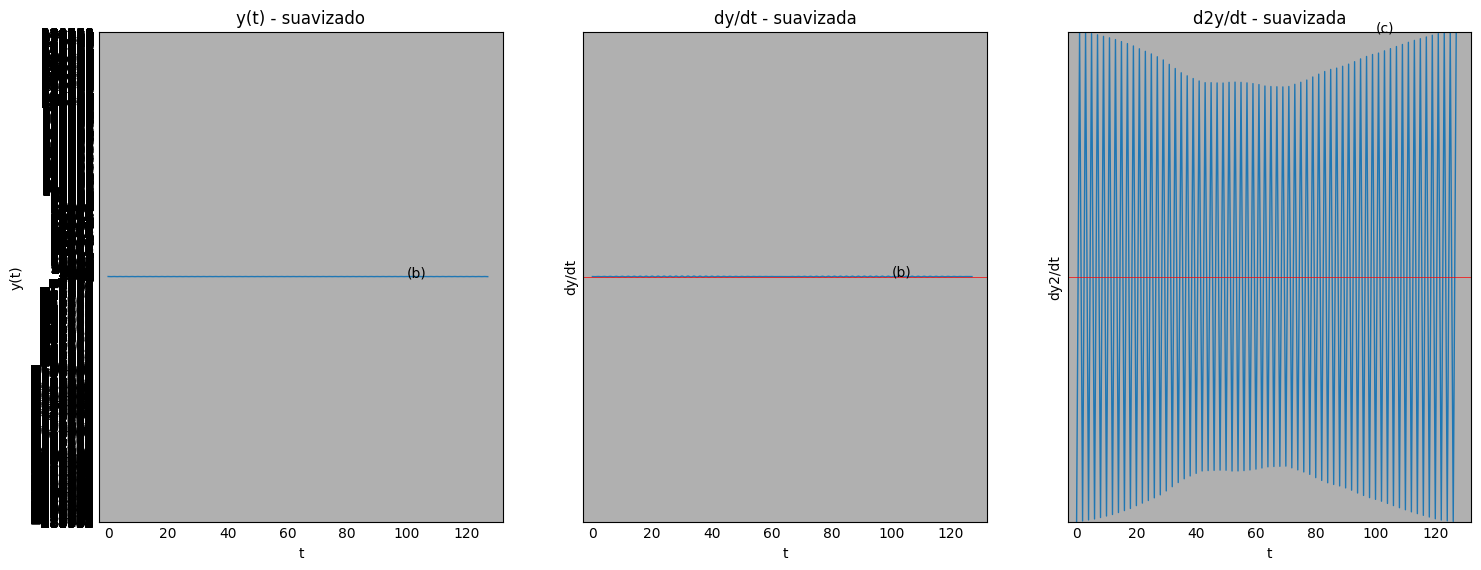

In [20]:
# Plota os valores das derivadas x(t), dx/dt e dx2/dt (original e deriv. de primeira e segunda ordem)
fig, axis = plt.subplots(1, 3, figsize=(14,5), sharey=True, sharex=True)  #layout = 'tight'
axis[0].plot(np.arange(n), triy,  linewidth=1.0)
axis[0].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str), \
       ylim=(np.min(triy)-3, np.max(triy)+3), 
       yticks=np.arange(np.min(triy),np.max(triy), 50), 
       xlabel= 't', ylabel = 'y(t)', title = 'y(t) - suavizado')
axis[0].text(100, np.max(triy)-10, '(b)')
#axis[0].axhline(0,0,1, linewidth = 0.5, color='r')

axis[1].plot(np.arange(n), dy,  linewidth=1.0)
axis[1].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str), \
       ylim=(np.min(dy)-3, np.max(dy)+3), 
       yticks=np.arange(np.floor(np.min(dy)),np.max(dy), 50), 
       xlabel= 't', ylabel = 'dy/dt', title = 'dy/dt - suavizada')
axis[1].text(100, np.max (dy)-10, '(b)')
axis[1].axhline(0,0,1, linewidth = 0.5, color='r')

axis[2].plot(np.arange(n), dy2,  linewidth=1.0)
axis[2].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str), \
       ylim=(np.min(dy2)-3, np.max(dy2)+3), 
       yticks=np.arange(np.floor(np.min(dy2)),np.max(dy2), 50), 
       xlabel= 't', ylabel = 'dy2/dt', title = 'd2y/dt - suavizada')
axis[2].text(100, np.max (dy2)-10, '(c)')
axis[2].axhline(0,0,1, linewidth = 0.5, color='r')

plt.subplots_adjust(wspace = 0.2)
plt.show()

In [21]:
# Calcula os pontos de curvatura
curv = np.zeros(n, dtype = float)
for t in np.arange(n):
  dm=(dx[t]**2+(dy[t])**2)**(3.0/2);
  curv[t]=((dx[t]*dy2[t])-(dx2[t]*dy[t]))/dm;

mcurv=np.abs(curv);   # ABS da curvatura 


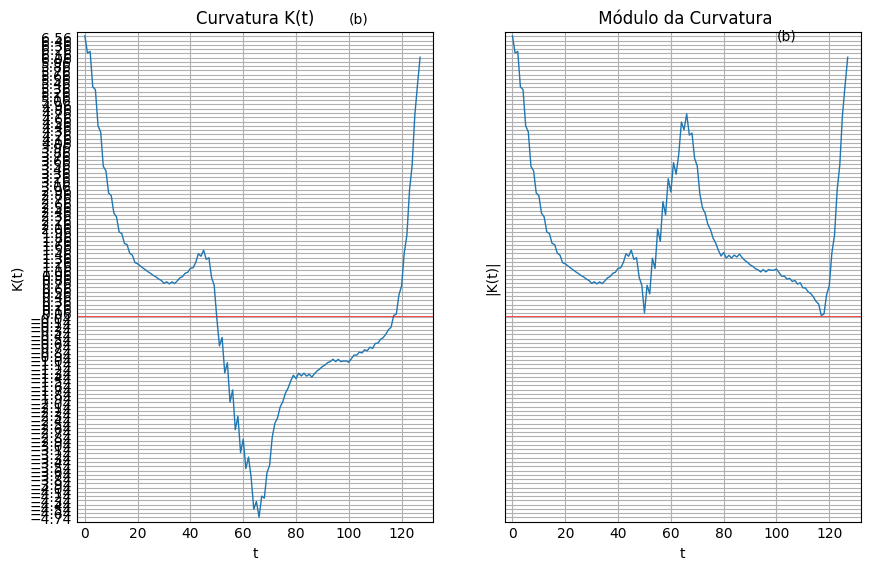

In [22]:
# Curvatura e abs(Curvatura)
fig, axis = plt.subplots(1, 2, figsize=(8,5), sharey=True, sharex=True)  #layout = 'tight'
axis[0].plot(np.arange(n), curv,  linewidth=1.0)
axis[0].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str), \
       ylim=(np.min(curv)-0.1, np.max(mcurv)+0.1), 
       yticks=np.arange(np.min(curv),np.max(mcurv), 0.1), 
       xlabel= 't', ylabel = 'K(t)', title = 'Curvatura K(t)')
axis[0].text(100, np.max(curv)+0.30, '(b)')
axis[0].axhline(0,0,1, linewidth = 0.5, color='r')

axis[1].plot(np.arange(n), mcurv,  linewidth=1.0)
axis[1].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str), \
       #ylim=(np.min(curv)-0.5, np.max(murv)+0.3), 
       #yticks=np.arange(np.min(curv),np.max(curv), 0.1), 
       xlabel= 't', ylabel = '|K(t)|', title = ' Módulo da Curvatura')
axis[1].text(100, np.max (mcurv)-0.1, '(b)')
axis[1].axhline(0,0,1, linewidth = 0.5, color='r')
plt.show()

In [23]:
# Calculo da 1a derivada do modulo da curvatura
tmcurv = np.zeros(n, dtype = complex)
dmcurv1 = np.zeros(n, dtype= complex)
dmcurv2 = np.zeros(n, dtype= complex)

for t in np.arange(n):
  tmcurv[t]=mcurv[t]*((-1)**(t))   #denovo antes de transformar???

fcurv=(np.fft.fft(tmcurv))/n
fcurv=fcurv*dgx
dmcurv=np.fft.ifft(fcurv)*n              
for t in np.arange(n):
  dmcurv1[t]=dmcurv[t]*((-1)**(t))        

In [24]:
# Calculo da 2a derivada do modulo da curvatura

fcurv=np.fft.fft(tmcurv)/n
fcurv=fcurv*dgx2
dmcurv=np.fft.ifft(fcurv)*n       
for t in np.arange(n):
 dmcurv2[t]=dmcurv[t]*((-1)**(t))   


c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:895: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))


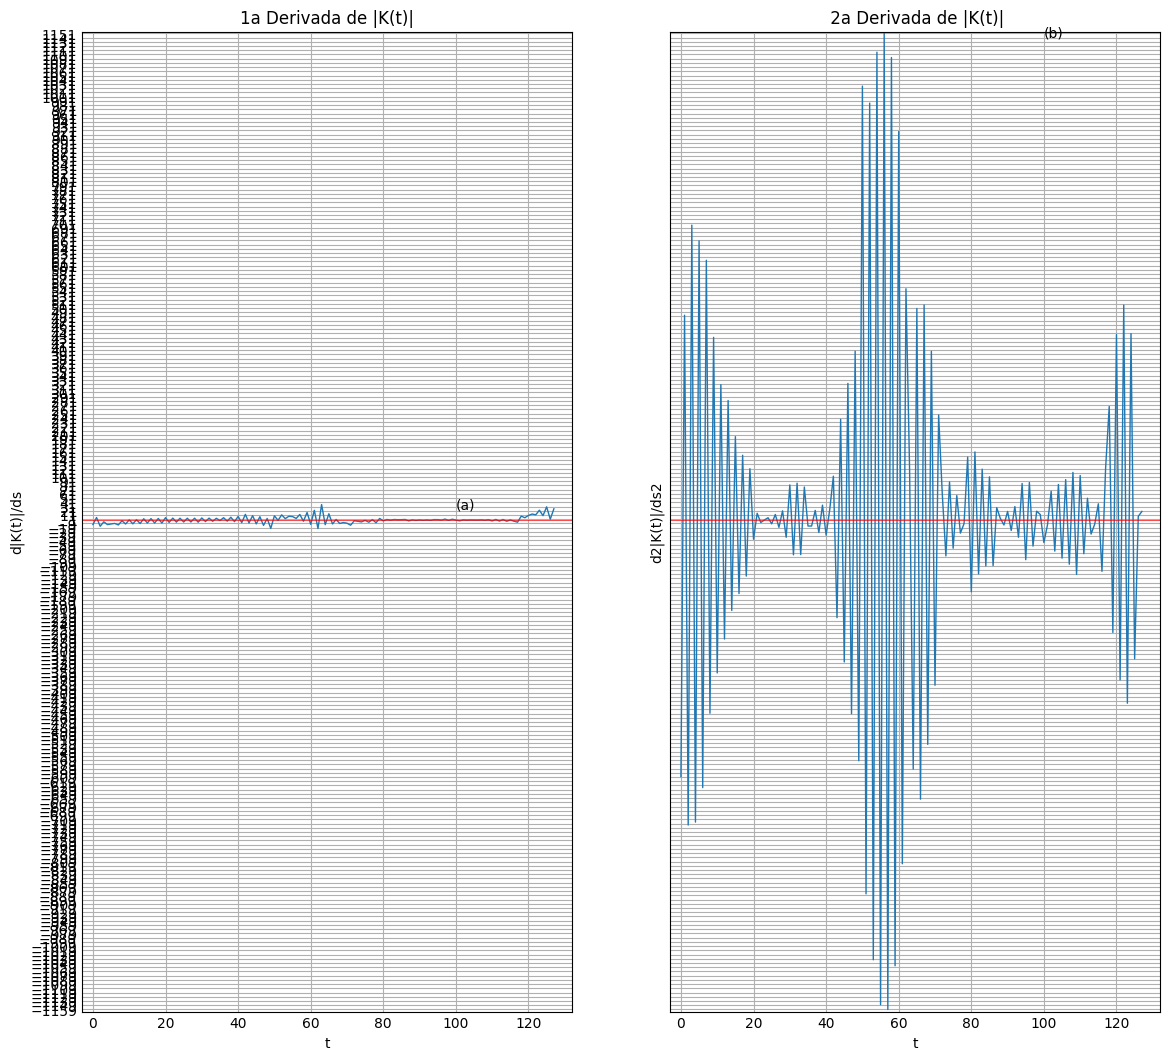

In [25]:
fig, axis = plt.subplots(1, 2, figsize=(11,10), sharey=True, sharex=True)  #layout = 'tight'
axis[0].plot(np.arange(n), np.real(dmcurv1),  linewidth=1.0)
axis[0].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str), \
       ylim=(np.min(np.real(dmcurv2)) - 5, np.max(np.real(dmcurv2))+ 3), 
       yticks=np.arange(np.min(np.real(dmcurv2)),np.max(np.real(dmcurv2)), 10), 
       xlabel= 't', ylabel = 'd|K(t)|/ds', title = '1a Derivada de |K(t)|')
axis[0].text(100, np.max(dmcurv1)-10, '(a)')
axis[0].axhline(0,0,1, linewidth = 0.5, color='r')

axis[1].plot(np.arange(n), np.real(dmcurv2),  linewidth=1.0)
axis[1].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 20), \
       xticklabels = np.array(np.arange(0, 129, 20), dtype = np.int32).astype(str), \
       xlabel= 't', ylabel = 'd2|K(t)|/ds2', title = ' 2a Derivada de |K(t)|')
axis[1].text(100, np.max (dmcurv2)-10, '(b)')
axis[1].axhline(0,0,1, linewidth = 0.5, color='r')
plt.show()


In [26]:
# Busca pelos pontos máximos de curvatura

# Busca os indices do vetor da primeira derivada de |k(t)|
# aproxima d(|K(t)|/ds onde ela corta o eixo das abcissas, ou seja, onde ela se proxima de zero

zero_cross= deque()
aux = np.real(dmcurv1)
for t in np.arange(n):
   if t < (n-1):
      if (np.sign(aux[t]) != np.sign(aux[t+1])):   #De: ????? não é  dmcurv2 (porque nao no mesmo i)
           zero_cross.appendleft(t)

## Pontos de máximo com base na 2a derivada de |K(t)| ((d2K/ds) < 0):
max_points_mcurv= deque()
aux = np.real(dmcurv2)
for t in  zero_cross:
   if (dmcurv2[t] <0):
      max_points_mcurv.appendleft(t)
   elif (dmcurv2[t+1] <0):
      max_points_mcurv.appendleft(t+1)  


c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:753: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:894: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
c:\Users\Daniela\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\text.py:895: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))


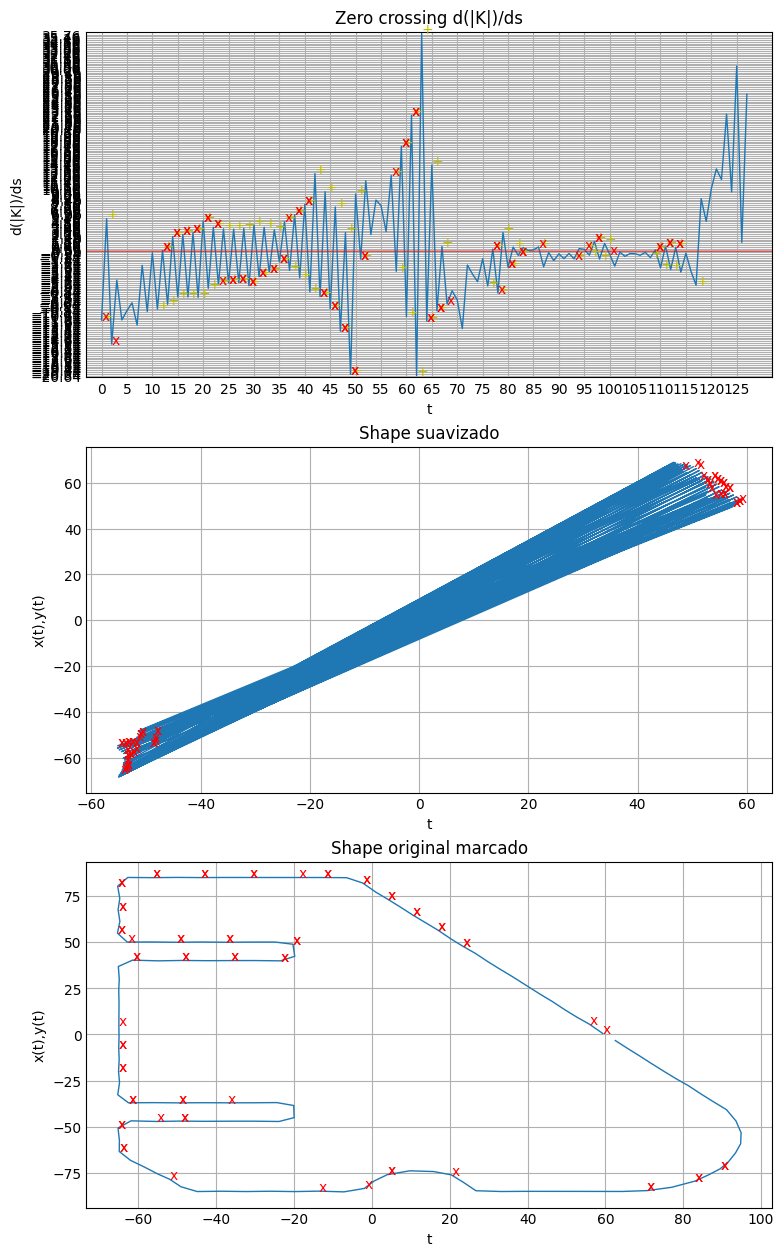

In [27]:
fig, axis = plt.subplots(3,1,figsize=(7,12)) #, sharex=True)  #layout = 'tight'
axis[0].plot(np.arange(n), np.real(dmcurv1),  linewidth=1.0)
axis[0].set(xlim=(-3, 129+3), xticks=np.arange(0, 129, 5), \
       xticklabels = np.array(np.arange(0, 129, 5), dtype = np.int32).astype(str), \
       ylim=(np.min(np.real(dmcurv1)) - 0.3, np.max(np.real(dmcurv1))+0.3), 
       yticks=np.arange(np.min(np.real(dmcurv1)),np.max(np.real(dmcurv1)), 0.3), 
       xlabel= 't', ylabel = 'd(|K|)/ds', title = 'Zero crossing d(|K|)/ds')
for t in zero_cross:
    axis[0].text(t, np.real(dmcurv1[t]), '+', color='y')
for t in max_points_mcurv:
    axis[0].text(t, np.real(dmcurv1[t]), 'x', color='r')    
axis[0].axhline(0,0,1, linewidth = 0.5, color='r')

# Shape após suavização:
axis[1].plot(np.real(trix), np.real(triy),  linewidth=1.0)
axis[1].set( #xlim=(np.real(trix)-3, np.real(triy)+3), xticks=np.arange(np.real(trix), np.real(triy), 10), \
       xlabel= 't', ylabel = 'x(t),y(t)', title = 'Shape suavizado')
for t in max_points_mcurv:
    axis[1].text(trix[t], triy[t], 'x', color='r')    
#axis[1].axhline(0,0,1, linewidth = 0.5, color='r') 

# Shape original:
axis[2].plot(np.real(xt), np.real(yt),  linewidth=1.0)
axis[2].set( #xlim=(np.real(trix)-3, np.real(triy)+3), xticks=np.arange(np.real(trix), np.real(triy), 10), \
       xlabel= 't', ylabel = 'x(t),y(t)', title = 'Shape original marcado')
for t in max_points_mcurv:
    axis[2].text(xt[t], yt[t], 'x', color='r')  

In [28]:
def calc_tresh_curvature(m_K, z_crossing):
    min = math.inf
    max = -math.inf
    for elem in m_k:
        if (elem < min):
            min = elem
        if (elem > max):
            max = elem
    amplitude = (max - min)
    zero_cross_amp = deque()
    for elem in z_crossing:
        zero_cross_amp
    candidates = {zero_cross: m_k[zero_cross]}

In [29]:
'''x = np.arange(-10,5,2)
i = np.array([7,2,3])
dic = (i,x)
dic    
footballers_goals = {'Eusebio': 120, 'Cruyff': 104, 'Pele': 150, 'Ronaldo': 132, 'Messi': 125}
sorted_footballers_by_goals = sorted(footballers_goals.items(), key=lambda x:x[1])

SyntaxError: incomplete input (938790653.py, line 1)